In [20]:
# -*- coding: utf-8 -*-

import sys,os
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import linalg
from numpy import dot
import geomloss as gs

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import grad
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.nn.modules import Linear
from torch.autograd.functional import jacobian,hessian,vjp,vhp,hvp

import random
import math

FilePath = "../../"
file_list = ['GSM1599494_ES_d0_main.csv', 'GSM1599497_ES_d2_LIFminus.csv', 'GSM1599498_ES_d4_LIFminus.csv', 'GSM1599499_ES_d7_LIFminus.csv']

table_list = []
for filein in file_list:
    table_list.append(pd.read_csv(FilePath+filein, header=None))

matrix_list = []
gene_names = table_list[0].values[:,0]
for table in table_list:
    matrix_list.append(table.values[:,1:].astype('float32'))

cell_counts = [matrix.shape[1] for matrix in matrix_list]

# normalization
def normalize_run(mat):
    rpm = np.sum(mat,0)/1e6
    detect_pr = np.sum(mat==0,0)/float(mat.shape[0])
    return np.log(mat*(np.median(detect_pr)/detect_pr)*1.0/rpm + 1.0)

norm_mat = [normalize_run(matrix) for matrix in matrix_list]

# order by Wasserstein distance
qt_mat = [np.percentile(norm_in,q=np.linspace(0,100,50),axis=1) for norm_in in norm_mat] 
wdiv=np.sum((qt_mat[0]-qt_mat[3])**2,0)
w_order = np.argsort(-wdiv)

wsub = w_order[0:100]

def nmf(X, latent_features, max_iter=100, error_limit=1e-6, fit_error_limit=1e-6, print_iter=200):
    """
    Decompose X to A*Y
    """
    eps = 1e-5
    print('Starting NMF decomposition with {} latent features and {} iterations.'.format(latent_features, max_iter))
    #X = X.toarray()   I am passing in a scipy sparse matrix

    # mask
    mask = np.sign(X)

    # initial matrices. A is random [0,1] and Y is A\X.
    rows, columns = X.shape
    A = np.random.rand(rows, latent_features) 
    A = np.maximum(A, eps)

    Y = linalg.lstsq(A, X)[0]
    Y = np.maximum(Y, eps)

    masked_X = mask * X
    X_est_prev = dot(A, Y)
    for i in range(1, max_iter + 1):
        # ===== updates =====
        # Matlab: A=A.*(((W.*X)*Y')./((W.*(A*Y))*Y'));
        top = dot(masked_X, Y.T)
        bottom = (dot((mask * dot(A, Y)), Y.T)) + eps
        A *= top / bottom

        A = np.maximum(A, eps)
        # print 'A',  np.round(A, 2)

        # Matlab: Y=Y.*((A'*(W.*X))./(A'*(W.*(A*Y))));
        top = dot(A.T, masked_X)
        bottom = dot(A.T, mask * dot(A, Y)) + eps
        Y *= top / bottom
        Y = np.maximum(Y, eps)
        # print 'Y', np.round(Y, 2)


        # ==== evaluation ====
        if i % print_iter == 0 or i == 1 or i == max_iter:
            print('Iteration {}:'.format(i),)
            X_est = dot(A, Y)
            err = mask * (X_est_prev - X_est)
            fit_residual = np.sqrt(np.sum(err ** 2))
            X_est_prev = X_est

            curRes = linalg.norm(mask * (X - X_est), ord='fro')
            print('fit residual', np.round(fit_residual, 4),)
            print('total residual', np.round(curRes, 4))
            if curRes < error_limit or fit_residual < fit_error_limit:
                break
    return A, Y, dot(A,Y)

np.random.seed(0)
norm_imputed = [nmf(normin[wsub,:], latent_features = len(wsub)*4, max_iter=500)[2] for normin in norm_mat]

norm_adj = np.mean(norm_imputed[3],1)[:,np.newaxis]
subvec = np.array([0,1,2,3,4,5,6,7,8,9])

gnvec = gene_names[w_order[subvec]]

cov_mat = np.cov(norm_imputed[3][subvec,:])
whiten = np.diag(np.diag(cov_mat)**(-0.5))
unwhiten = np.diag(np.diag(cov_mat)**(0.5))

norm_imputed2 = [np.dot(whiten,(normin - norm_adj)[subvec,:]) for normin in norm_imputed]

Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 4000.1233
total residual 138.7959
Iteration 200:
fit residual 123.6643
total residual 31.8464
Iteration 400:
fit residual 21.7894
total residual 12.6115
Iteration 500:
fit residual 4.3442
total residual 8.6686
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2257.8358
total residual 58.2265
Iteration 200:
fit residual 56.8198
total residual 4.0447
Iteration 400:
fit residual 3.4777
total residual 0.6841
Iteration 500:
fit residual 0.3744
total residual 0.3185
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2925.3664
total residual 80.2657
Iteration 200:
fit residual 78.1148
total residual 6.1559
Iteration 400:
fit residual 5.1661
total residual 1.1917
Iteration 500:
fit residual 0.6183
total residual 0.5917
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
f

In [21]:
def setup_seed(seed):
     torch.cuda.manual_seed(seed)
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.benchmark=False
     torch.backends.cudnn.deterministic = True
setup_seed(100)

class MLP(nn.Module):

    def __init__(self, dim_in, dim_out, dim_hidden=64, num_hidden=0, activation=nn.LeakyReLU()):
        super(MLP, self).__init__()

        if num_hidden == 0:
            self.linears = nn.ModuleList([nn.Linear(dim_in, dim_out)])
        elif num_hidden >= 1:
            self.linears = nn.ModuleList() 
            self.linears.append(nn.Linear(dim_in, dim_hidden))
            self.linears.extend([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_hidden-1)])
            self.linears.append(nn.Linear(dim_hidden, dim_out))
        else:
            raise Exception('number of hidden layers must be positive')

        for m in self.linears:
            nn.init.xavier_normal_(m.weight)
            nn.init.uniform_(m.bias,a=-0.1,b=0.1)
 
        self.activation = activation

    def forward(self, x):
        for m in self.linears[:-1]:
            x = self.activation(m(x))
            x = F.dropout(x,p=0.5)

        return self.linears[-1](x)
    
def compute_gradient_penalty(D, real_sample, fake_sample,k,p):
    real_samples = real_sample.requires_grad_(True)
    fake_samples = fake_sample.requires_grad_(True)

    real_validity = D(real_samples)
    fake_validity = D(fake_samples)

    real_grad_out = torch.ones((real_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    real_grad = grad(
        real_validity, real_samples, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    fake_grad_out = torch.ones((fake_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    fake_grad = grad(
        fake_validity, fake_samples, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    return (torch.sum(real_grad_norm) + torch.sum(fake_grad_norm)) * k / (real_sample.shape[0]+fake_sample.shape[0])

# generator
class JumpEulerForwardCuda(nn.Module):
    def __init__(self,in_features,num_hidden,dim_hidden,step_size,intensity,bd):
        super(JumpEulerForwardCuda,self).__init__()

        self.drift = MLP(in_features,in_features,dim_hidden,num_hidden)
        self.intensity = torch.tensor(intensity,device="cuda")
        self.mean = nn.Parameter(0.01*torch.ones(10))
        self.covHalf = nn.Parameter(0.08*torch.eye(10))
        self.diffusion = nn.Parameter(torch.ones(bd,10))
        self.in_features = in_features
        self.jump = MLP(in_features,in_features,dim_hidden,num_hidden)
        self.step_size = step_size

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            DP = D.poisson.Poisson(self.intensity*self.step_size) 
            pois = DP.sample((Nsim,1)).cuda()
            state = state + self.drift(state)*self.step_size + math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,bd),device="cuda")@self.diffusion+\
                (pois*self.mean + pois**(0.5)*torch.normal(0,1,size=(Nsim,10),device="cuda")@self.covHalf)*self.jump(state)
            PopulationPath[:,i,:] = state
        return PopulationPath

In [22]:
# training data
train_data = norm_imputed2

train0 = torch.tensor(train_data[0],dtype=torch.float32,requires_grad = True,device="cuda").t()
train2 = torch.tensor(train_data[1],dtype=torch.float32,requires_grad = True,device="cuda").t()
train4 = torch.tensor(train_data[2],dtype=torch.float32,requires_grad = True,device="cuda").t()
train7 = torch.tensor(train_data[3],dtype=torch.float32,requires_grad = True,device="cuda").t()

n_sims = train0.shape[0]
in_features = train0.shape[1]

### hyperparameters
n_steps = [10,20,35]
step_size = 0.05
bd = 2
intensity = 200
lr = 0.0001
k = 2
p = 6
num_hidden = 3
dim_hidden = 64

# create generator and critic
netG = JumpEulerForwardCuda(10,num_hidden,dim_hidden,step_size,intensity,bd).cuda()
netD1 = MLP(10,1,dim_hidden,num_hidden).cuda()
netD2 = MLP(10,1,dim_hidden,num_hidden).cuda()


optimizerG = optim.AdamW(netG.parameters(), lr=lr, weight_decay=0.001)
optimizerSD1 = optim.Adam(netD1.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD2 = optim.Adam(netD2.parameters(), lr=lr, betas=(0.5, 0.999))

In [23]:
a = gs.SamplesLoss(loss='sinkhorn',p=2,blur=0.01)

In [24]:
n_epochs = 5000
for epoch in range(n_epochs):
  
    
    # -------------------
    # critic
    # -------------------
    


    for _ in range(5): 
        fake_data = netG(train0,n_sims,n_steps[2])
        fake1 = fake_data[:,n_steps[0],:]
        fake2 = fake_data[:,n_steps[1],:]

        optimizerSD1.zero_grad()

        div_gp1 = compute_gradient_penalty(netD1,train2,fake1,k,p)
        d1_loss = -torch.mean(netD1(train2))+torch.mean(netD1(fake1))+div_gp1
        d1_loss.backward(retain_graph=True) # retain_graph=True

        optimizerSD1.step()

        optimizerSD2.zero_grad()
        
        div_gp2 = compute_gradient_penalty(netD2,train4,fake2,k,p)
        d2_loss = -torch.mean(netD2(train4))+torch.mean(netD2(fake2))+div_gp2
        d2_loss.backward(retain_graph=True)

        optimizerSD2.step()
        


    # ----------------
    # generator
    # ----------------

    
    for _ in range(1):
        optimizerG.zero_grad()
        
        fake_data = netG(train0,n_sims,n_steps[2])
        fake1 = fake_data[:,n_steps[0],:]
        fake2 = fake_data[:,n_steps[1],:]
        g_loss = -torch.mean(netD1(fake1))-torch.mean(netD2(fake2))
        g_loss.backward() 

        optimizerG.step()

    if epoch %10==0:
        print("epoch:",epoch,";", "d1_loss:",(-d1_loss+div_gp1).item(),";","d2_loss:",(-d2_loss+div_gp2).item(),";","g_loss:",g_loss.item())
        print("epoch: ",epoch,"training1: ",a(fake_data[:,n_steps[0],:],train2).item(),"training2: ",a(fake_data[:,n_steps[1],:],train4).item())
        

epoch: 0 ; d1_loss: 0.4974842071533203 ; d2_loss: -2.285865306854248 ; g_loss: -2.741837978363037
epoch:  0 training1:  48.010345458984375 training2:  151.8455352783203
epoch: 10 ; d1_loss: 1.3506269454956055 ; d2_loss: -0.8328006267547607 ; g_loss: 1.8995009660720825
epoch:  10 training1:  58.69074249267578 training2:  200.79226684570312
epoch: 20 ; d1_loss: 2.144686460494995 ; d2_loss: 1.4357436895370483 ; g_loss: 6.483489990234375
epoch:  20 training1:  52.25458526611328 training2:  188.24172973632812
epoch: 30 ; d1_loss: 2.0349349975585938 ; d2_loss: 2.843061923980713 ; g_loss: 8.695842742919922
epoch:  30 training1:  42.51318359375 training2:  130.26187133789062
epoch: 40 ; d1_loss: 1.596954107284546 ; d2_loss: 2.8543787002563477 ; g_loss: 8.277393341064453
epoch:  40 training1:  31.26912498474121 training2:  85.44140625
epoch: 50 ; d1_loss: 1.3404662609100342 ; d2_loss: 2.2688095569610596 ; g_loss: 7.741091251373291
epoch:  50 training1:  25.71080780029297 training2:  60.14096069

epoch: 480 ; d1_loss: 0.7422767877578735 ; d2_loss: 0.555626392364502 ; g_loss: 1.3484413623809814
epoch:  480 training1:  4.766899585723877 training2:  6.2753095626831055
epoch: 490 ; d1_loss: 0.8632874488830566 ; d2_loss: 0.5938187837600708 ; g_loss: 1.2624104022979736
epoch:  490 training1:  4.578422546386719 training2:  6.0802903175354
epoch: 500 ; d1_loss: 0.6917582750320435 ; d2_loss: 0.5390254259109497 ; g_loss: 1.2850022315979004
epoch:  500 training1:  4.534004211425781 training2:  5.903388023376465
epoch: 510 ; d1_loss: 0.838815450668335 ; d2_loss: 0.549927830696106 ; g_loss: 1.0639253854751587
epoch:  510 training1:  4.534623146057129 training2:  5.950617790222168
epoch: 520 ; d1_loss: 0.816900372505188 ; d2_loss: 0.5077017545700073 ; g_loss: 1.0363661050796509
epoch:  520 training1:  4.7823638916015625 training2:  5.893197059631348
epoch: 530 ; d1_loss: 0.7737129926681519 ; d2_loss: 0.6477230787277222 ; g_loss: 0.9911145567893982
epoch:  530 training1:  4.064501762390137 tr

epoch: 960 ; d1_loss: 0.49625808000564575 ; d2_loss: 0.5912964940071106 ; g_loss: 1.6681463718414307
epoch:  960 training1:  3.2870562076568604 training2:  3.1892926692962646
epoch: 970 ; d1_loss: 0.51419997215271 ; d2_loss: 0.523464024066925 ; g_loss: 1.5298082828521729
epoch:  970 training1:  3.4076242446899414 training2:  3.0328140258789062
epoch: 980 ; d1_loss: 0.5260915160179138 ; d2_loss: 0.4744946360588074 ; g_loss: 1.1308283805847168
epoch:  980 training1:  3.7553365230560303 training2:  3.608203411102295
epoch: 990 ; d1_loss: 0.6230458617210388 ; d2_loss: 0.5199593901634216 ; g_loss: 0.4230118691921234
epoch:  990 training1:  3.847118616104126 training2:  3.7286603450775146
epoch: 1000 ; d1_loss: 0.47011035680770874 ; d2_loss: 0.3861139714717865 ; g_loss: 0.29548776149749756
epoch:  1000 training1:  3.3529715538024902 training2:  2.927093029022217
epoch: 1010 ; d1_loss: 0.4146232008934021 ; d2_loss: 0.3716036081314087 ; g_loss: 1.4129750728607178
epoch:  1010 training1:  3.428

epoch: 1430 ; d1_loss: 0.3831561803817749 ; d2_loss: 0.39499330520629883 ; g_loss: 2.6145544052124023
epoch:  1430 training1:  3.2052254676818848 training2:  2.8110361099243164
epoch: 1440 ; d1_loss: 0.47168946266174316 ; d2_loss: 0.342877060174942 ; g_loss: 1.4689552783966064
epoch:  1440 training1:  3.4519283771514893 training2:  3.199326753616333
epoch: 1450 ; d1_loss: 0.5526698231697083 ; d2_loss: 0.4237869381904602 ; g_loss: 0.45938971638679504
epoch:  1450 training1:  3.551051616668701 training2:  3.183445692062378
epoch: 1460 ; d1_loss: 0.36317580938339233 ; d2_loss: 0.30900996923446655 ; g_loss: -0.006107211112976074
epoch:  1460 training1:  3.145655632019043 training2:  2.3617701530456543
epoch: 1470 ; d1_loss: 0.3292555510997772 ; d2_loss: 0.44487184286117554 ; g_loss: 0.7612354159355164
epoch:  1470 training1:  3.2760798931121826 training2:  3.7141170501708984
epoch: 1480 ; d1_loss: 0.3785821199417114 ; d2_loss: 0.6175229549407959 ; g_loss: 2.191866397857666
epoch:  1480 tra

epoch: 1900 ; d1_loss: 0.37450218200683594 ; d2_loss: 0.7611991167068481 ; g_loss: 2.9340226650238037
epoch:  1900 training1:  2.894953727722168 training2:  3.6723711490631104
epoch: 1910 ; d1_loss: 0.40081238746643066 ; d2_loss: 0.5455477237701416 ; g_loss: 3.7264294624328613
epoch:  1910 training1:  2.8360648155212402 training2:  2.6433165073394775
epoch: 1920 ; d1_loss: 0.4931219220161438 ; d2_loss: 0.1720750331878662 ; g_loss: 2.9333229064941406
epoch:  1920 training1:  3.015810966491699 training2:  2.3347764015197754
epoch: 1930 ; d1_loss: 0.6325579881668091 ; d2_loss: 0.23296688497066498 ; g_loss: 1.553542137145996
epoch:  1930 training1:  3.3182506561279297 training2:  3.5514426231384277
epoch: 1940 ; d1_loss: 0.5053263306617737 ; d2_loss: 0.5133706331253052 ; g_loss: -0.0816163420677185
epoch:  1940 training1:  3.3790438175201416 training2:  4.137195587158203
epoch: 1950 ; d1_loss: 0.488142728805542 ; d2_loss: 0.6685359477996826 ; g_loss: -1.5477261543273926
epoch:  1950 traini

epoch: 2370 ; d1_loss: 0.5421435832977295 ; d2_loss: 0.30038222670555115 ; g_loss: 0.3957973122596741
epoch:  2370 training1:  2.806028127670288 training2:  2.367387533187866
epoch: 2380 ; d1_loss: 0.4102455973625183 ; d2_loss: 0.39677321910858154 ; g_loss: 0.28045088052749634
epoch:  2380 training1:  2.8952291011810303 training2:  2.257770538330078
epoch: 2390 ; d1_loss: 0.4759797751903534 ; d2_loss: 0.34191665053367615 ; g_loss: 0.38862213492393494
epoch:  2390 training1:  2.8420767784118652 training2:  2.0232107639312744
epoch: 2400 ; d1_loss: 0.5093206167221069 ; d2_loss: 0.40537697076797485 ; g_loss: 0.7748470902442932
epoch:  2400 training1:  2.7432761192321777 training2:  2.2255489826202393
epoch: 2410 ; d1_loss: 0.42925161123275757 ; d2_loss: 0.33067840337753296 ; g_loss: 1.2758405208587646
epoch:  2410 training1:  2.8521084785461426 training2:  2.4550085067749023
epoch: 2420 ; d1_loss: 0.46689099073410034 ; d2_loss: 0.39497870206832886 ; g_loss: 1.344456672668457
epoch:  2420 

epoch: 2840 ; d1_loss: 0.41745704412460327 ; d2_loss: 0.24310481548309326 ; g_loss: 1.162947416305542
epoch:  2840 training1:  2.6079635620117188 training2:  2.1749730110168457
epoch: 2850 ; d1_loss: 0.619438648223877 ; d2_loss: 0.31814685463905334 ; g_loss: 0.6957863569259644
epoch:  2850 training1:  2.8109498023986816 training2:  2.658717155456543
epoch: 2860 ; d1_loss: 0.40340617299079895 ; d2_loss: 0.36528313159942627 ; g_loss: -0.15031243860721588
epoch:  2860 training1:  2.528430700302124 training2:  2.7043588161468506
epoch: 2870 ; d1_loss: 0.4673486053943634 ; d2_loss: 0.2691294252872467 ; g_loss: -0.48168569803237915
epoch:  2870 training1:  2.495816469192505 training2:  2.3345985412597656
epoch: 2880 ; d1_loss: 0.48316144943237305 ; d2_loss: 0.5868016481399536 ; g_loss: 0.2990630567073822
epoch:  2880 training1:  2.4469146728515625 training2:  2.582439422607422
epoch: 2890 ; d1_loss: 0.47311824560165405 ; d2_loss: 0.34191423654556274 ; g_loss: 0.7574799060821533
epoch:  2890 

epoch: 3310 ; d1_loss: 0.4991428256034851 ; d2_loss: 0.2641662359237671 ; g_loss: 1.7125191688537598
epoch:  3310 training1:  2.713015079498291 training2:  2.8325400352478027
epoch: 3320 ; d1_loss: 0.40637069940567017 ; d2_loss: 0.13708919286727905 ; g_loss: 0.8095690011978149
epoch:  3320 training1:  2.340718984603882 training2:  2.4291718006134033
epoch: 3330 ; d1_loss: 0.4521838426589966 ; d2_loss: 0.3323590159416199 ; g_loss: 0.11545605957508087
epoch:  3330 training1:  2.3841803073883057 training2:  2.4886391162872314
epoch: 3340 ; d1_loss: 0.4362931549549103 ; d2_loss: 0.4459540843963623 ; g_loss: -0.4033380448818207
epoch:  3340 training1:  2.316946268081665 training2:  2.7091917991638184
epoch: 3350 ; d1_loss: 0.43808507919311523 ; d2_loss: 0.3674197494983673 ; g_loss: -0.9024906158447266
epoch:  3350 training1:  2.2919249534606934 training2:  2.4898037910461426
epoch: 3360 ; d1_loss: 0.33513343334198 ; d2_loss: 0.26160889863967896 ; g_loss: -0.9193729758262634
epoch:  3360 tra

epoch: 3780 ; d1_loss: 0.48194634914398193 ; d2_loss: 0.12067240476608276 ; g_loss: 0.3656139373779297
epoch:  3780 training1:  2.573122501373291 training2:  2.930609703063965
epoch: 3790 ; d1_loss: 0.45618152618408203 ; d2_loss: 0.28434062004089355 ; g_loss: -0.05719834566116333
epoch:  3790 training1:  2.543781280517578 training2:  3.048771858215332
epoch: 3800 ; d1_loss: 0.36740511655807495 ; d2_loss: 0.3311254382133484 ; g_loss: -0.37077775597572327
epoch:  3800 training1:  2.1899094581604004 training2:  2.6245765686035156
epoch: 3810 ; d1_loss: 0.33597758412361145 ; d2_loss: 0.20625421404838562 ; g_loss: -0.6020295023918152
epoch:  3810 training1:  2.2576889991760254 training2:  2.615670919418335
epoch: 3820 ; d1_loss: 0.38312697410583496 ; d2_loss: 0.3294076919555664 ; g_loss: -0.048328548669815063
epoch:  3820 training1:  2.192322015762329 training2:  3.385979652404785
epoch: 3830 ; d1_loss: 0.4275696873664856 ; d2_loss: 0.48433220386505127 ; g_loss: 1.0260131359100342
epoch:  3

epoch: 4250 ; d1_loss: 0.5139596462249756 ; d2_loss: 0.3210657238960266 ; g_loss: 0.14508910477161407
epoch:  4250 training1:  2.271439552307129 training2:  3.0609869956970215
epoch: 4260 ; d1_loss: 0.3513685464859009 ; d2_loss: 0.2953311502933502 ; g_loss: -0.3966369926929474
epoch:  4260 training1:  2.1380629539489746 training2:  2.4666025638580322
epoch: 4270 ; d1_loss: 0.3554099202156067 ; d2_loss: 0.25674623250961304 ; g_loss: -0.7372251152992249
epoch:  4270 training1:  2.098788022994995 training2:  2.3296728134155273
epoch: 4280 ; d1_loss: 0.35476869344711304 ; d2_loss: 0.30115747451782227 ; g_loss: -0.47123461961746216
epoch:  4280 training1:  1.9459819793701172 training2:  2.5220956802368164
epoch: 4290 ; d1_loss: 0.37439998984336853 ; d2_loss: 0.4115944504737854 ; g_loss: 0.30082887411117554
epoch:  4290 training1:  2.0014774799346924 training2:  2.6454782485961914
epoch: 4300 ; d1_loss: 0.39752838015556335 ; d2_loss: 0.27657216787338257 ; g_loss: 0.7884587645530701
epoch:  4

epoch: 4720 ; d1_loss: 0.2961041331291199 ; d2_loss: 0.14102208614349365 ; g_loss: -2.4796550273895264
epoch:  4720 training1:  1.9660989046096802 training2:  2.008110284805298
epoch: 4730 ; d1_loss: 0.24931997060775757 ; d2_loss: 0.024098515510559082 ; g_loss: -1.7404260635375977
epoch:  4730 training1:  1.920217752456665 training2:  3.0844228267669678
epoch: 4740 ; d1_loss: 0.39518648386001587 ; d2_loss: 0.29224205017089844 ; g_loss: 0.1597997546195984
epoch:  4740 training1:  2.001776695251465 training2:  3.9713990688323975
epoch: 4750 ; d1_loss: 0.29124951362609863 ; d2_loss: 0.8326582908630371 ; g_loss: 3.1982948780059814
epoch:  4750 training1:  2.056356430053711 training2:  3.7364275455474854
epoch: 4760 ; d1_loss: 0.3846551179885864 ; d2_loss: 0.3526875972747803 ; g_loss: 2.8924684524536133
epoch:  4760 training1:  1.9499953985214233 training2:  2.398606061935425
epoch: 4770 ; d1_loss: 0.4715738892555237 ; d2_loss: -0.011015893891453743 ; g_loss: 1.533693552017212
epoch:  4770 

In [25]:
torch.save(netG.state_dict(),"./SDEgauJump_Task2.pt")

tensor(7.3074, device='cuda:0', grad_fn=<SelectBackward>)
0.6071423015656641
0.6564163311981355
1.5818803794972358
0.9435936150096983
0.6675876976095931
1.1225628222922919
0.7953009195021044
1.018050400393017
0.33581877430568574
1.7164379397328633


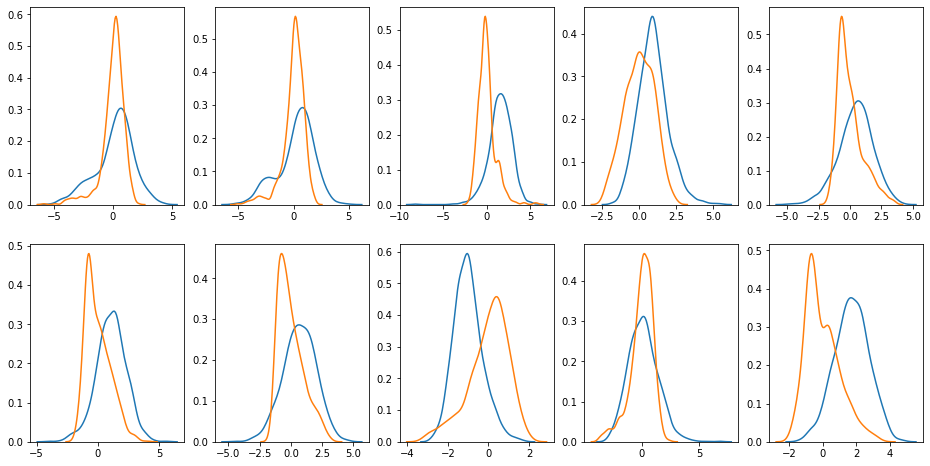

In [26]:
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

setup_seed(305)

path = netG(train0,train0.shape[0],35)
G7 = path[:,-1,:]

print(a(G7,train7))

T4 = train7.detach().cpu().numpy()
G7 = G7.detach().cpu().numpy()

for i in range(10):
    print(scipy.stats.wasserstein_distance(G7[:,i],T7[:,i]))

plt.figure(figsize=(16,8))
plt.subplot(2,5,1)
sns.kdeplot(G7[:,0])
sns.kdeplot(T7[:,0])

plt.subplot(2,5,2)
sns.kdeplot(G7[:,1])
sns.kdeplot(T7[:,1])

plt.subplot(2,5,3)
sns.kdeplot(G7[:,2])
sns.kdeplot(T7[:,2])

plt.subplot(2,5,4)
sns.kdeplot(G7[:,3])
sns.kdeplot(T7[:,3])

plt.subplot(2,5,5)
sns.kdeplot(G7[:,4])
sns.kdeplot(T7[:,4])

plt.subplot(2,5,6)
sns.kdeplot(G7[:,5])
sns.kdeplot(T7[:,5])

plt.subplot(2,5,7)
sns.kdeplot(G7[:,6])
sns.kdeplot(T7[:,6])

plt.subplot(2,5,8)
sns.kdeplot(G7[:,7])
sns.kdeplot(T7[:,7])

plt.subplot(2,5,9)
sns.kdeplot(G7[:,8])
sns.kdeplot(T7[:,8])

plt.subplot(2,5,10)
sns.kdeplot(G7[:,9])
sns.kdeplot(T7[:,9])